In [61]:
#%matplotlib tk
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path

import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time

# pytorch for GPU
import torch

import LocaNMF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


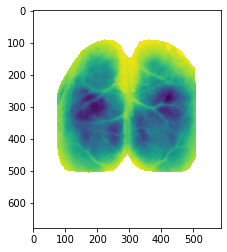

In [62]:
# allen map folder
mapfolder='/home/cat/code/self_initiated_alex_locaNMF/locaNMF/data/AllenMap/'

# data location
Uc_fname = '/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Uc_500SVD_GPU_registered.npy'
Vc_fname = '/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Vc_500SVD_GPU.npy'
root_dir = os.path.split(Vc_fname)[0]+'/'

# brain mask
fname_mask = '/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Uc_aligned_brainmask.npy'
plt.imshow(np.load(fname_mask))


# user params
minrank = 1; maxrank = 1; # rank = how many components per brain region. Set maxrank to around 10 for regular dataset.
rank_range = (minrank, maxrank, 1)
min_pixels = 100 # minimum number of pixels in Allen map for it to be considered a brain region
loc_thresh = 50 # Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
r2_thresh = 0.99 # Fraction of variance in the data to capture with LocaNMF

## [OPTIONAL] if cuda support, uncomment following lines
if True:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    device='cuda'
else:
    # else, if on cpu
    device='cpu'

In [34]:
# data = np.load('/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Uc_500SVD_GPU_registered.npy')
# print (data.shape)
# data = np.load('/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Uc_aligned_brainmask.npy')
# print (data.shape)
# data = np.load('/media/cat/1TB/data/yuki/IA2am_Mar9_30Hz_aligned_Vc_500SVD_GPU.npy')
# print (data.shape)

(679, 586, 500)
(679, 586)
(500, 40000)


(679, 586)


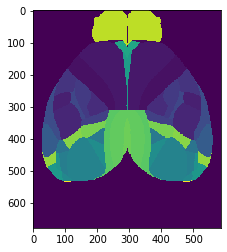

In [63]:
# Load Allen Brain Map
# Get data from this link--> https://www.dropbox.com/s/q4m1v151o06zsdv/Vc_Uc.mat?dl=0
# Get map here if you do not have it--> https://www.dropbox.com/s/d35xt7e6l2ywiol/preprocessed_allenDorsalMap.mat?dl=0
dorsalMapScaled = sio.loadmat(mapfolder+'preprocessed_allenDorsalMap.mat')['dorsalMapScaled'].astype(float)
print (dorsalMapScaled.shape)
plt.imshow(dorsalMapScaled)
plt.show()

In [64]:
# Load Vc and Uc data
# Brainmask limits x and y
new_x, new_y = 580, 540 
#V=arrays['Vc']
V=np.load(Vc_fname)
#U=arrays['Uc'][:new_y, :new_x, :]
U=np.load(Uc_fname)[:new_y, :new_x, :]

print ("V : ", V.shape)
print ("U : ", U.shape)


V :  (500, 40000)
U :  (540, 580, 500)


In [65]:
# load Uc spatial components and crop if required
class crop(object):
    def __init__(self,data, fname):
        self.data = data
        self.fname = fname

        self.define_ROI()

    def define_ROI(self):

        #if os.path.exists(self.fname[:-4]+".npy")==False:
        roi_coords = self.select_ROI()

        return (roi_coords) 

    def select_ROI(self):
        ''' Function to crop field-of-view of video
        '''

        self.fig, self.ax = plt.subplots()
        self.coords=[]

        self.sample_image = data[1]
        print (self.sample_image.shape)
        self.ax.imshow(self.sample_image)#, vmin=0.0, vmax=0.02)
        #self.ax.set_title(ROI_name)

        #figManager = plt.get_current_fig_manager()
        #figManager.window.showMaximized()
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        plt.show(block=False)

    def on_click(self, event):
        ''' Mouse click function that catches clicks and plots them on top of existing image
        '''

        if event.inaxes is not None:
            print (event.ydata, event.xdata)
            self.coords.append((event.ydata, event.xdata))
            #for j in range(len(self.coords)):
            for k in range(2):
                for l in range(2):
                    self.sample_image[int(event.ydata)-1+k,int(event.xdata)-1+l]=np.max(self.sample_image)

            self.ax.imshow(self.sample_image)
            self.fig.canvas.draw()
        else:
            print ('Exiting')
            plt.close()
            #self.fig.canvas.mpl_disconnect(self.cid)
            np.save(self.fname[:-4]+"_coords.npy", self.coords)

            return



    
f_out = 'crop file name'
if False:
    if os.path.exists(f_out)==False:
        data = np.load(fname).transpose(2,0,1)
        #data = np.load('/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2am_Mar9_30Hz/IA2am_Mar9_30Hz_aligned_Uc_500SVD_GPU.npy')
        print (data.shape)

        crop(data, fname)


In [66]:
# load coords and visualized cropped data
#f_out = fname[:-4]+"_brainmask.npy"
if False:
    if os.path.exists(f_out)==False:

        data = np.load(fname).transpose(2,0,1)
        coords = np.load(fname[:-4]+"_coords.npy")

        data = data[0]
        #Search points outside and black them out:
        all_points = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                all_points.append([i,j])

        all_points = np.array(all_points)
        vertixes = np.array(coords) 
        vertixes_path = Path(vertixes)

        mask = vertixes_path.contains_points(all_points)
        print (mask.shape)
        counter=0
        coords_save=[]
        images_processed = data
        print (images_processed.shape)
        for i in range(images_processed.shape[0]):
            for j in range(images_processed.shape[1]):
                if mask[counter] == False:
                    images_processed[i][j]=np.nan
                    coords_save.append([i,j])
                counter+=1

        final_mask = images_processed
        np.save(fname[:-4]+"_brainmask.npy", final_mask)
        fig, ax = plt.subplots()
        ax.imshow(images_processed)
        plt.show()




branimask:  (540, 580)
branimask full:  (679, 586)


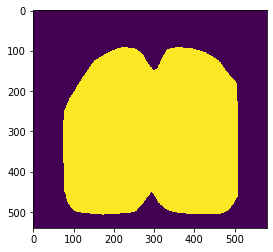

In [67]:
#brainmask=~np.isnan(arrays['brainmask'][:new_y, :new_x])
#brainmask_full=~np.isnan(arrays['brainmask'])
#trueareas=arrays['trueareas'].flatten()
mask = np.load(fname_mask)
brainmask=~np.isnan(mask[:new_y, :new_x])
brainmask_full=~np.isnan(mask)

print ("branimask: ", brainmask.shape)
print ("branimask full: ", brainmask_full.shape)

plt.imshow(brainmask)
plt.show()


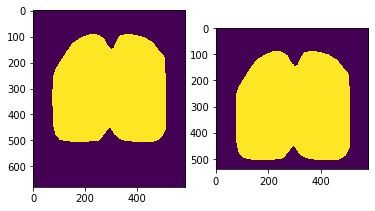

In [68]:
# ax=plt.subplot(121)
# plt.imshow(brainmask_full)
# ax=plt.subplot(122)
# plt.imshow(brainmask)
# plt.show()


In [69]:
# Divide up region based Allen map into left and right sides
dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] = dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] * -1
dorsalMapScaled = -dorsalMapScaled[:new_y, :new_x]

Rank of video : 500
Number of timepoints : 40000


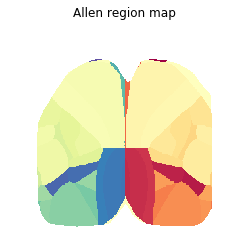

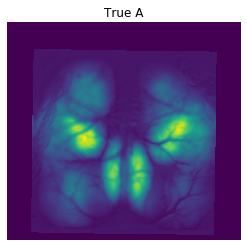

In [70]:
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
if V.shape[0]!=U.shape[-1]: print('Wrong dimensions of U and V!')
print("Rank of video : %d" % V.shape[0]); print("Number of timepoints : %d" % V.shape[1]); 

# Plot the maximum U for each pixel
plotmap=np.zeros((dorsalMapScaled.shape)); plotmap.fill(np.nan); plotmap[brainmask]=dorsalMapScaled[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(U,axis=2)); plt.axis('off'); plt.title('True A'); plt.show()

In [71]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [72]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)

del U

In [73]:
# GET LABELS FOR EACH CELL FROM SHREYA
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(brainmask,
                                            dorsalMapScaled,
                                            min_size=min_pixels)

In [74]:
# GET LABELS FOR EACH CELL FROM SHREYA
region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [75]:
# GET LABELS FOR EACH CELL FROM SHREYA
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1],
                                           device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 5.636287


In [76]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(brainmask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# LocaNMF

In [77]:
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
locanmf_comps = LocaNMF.rank_linesearch(low_rank_video,
                                      region_metadata,
                                      region_videos,
                                      maxiter_rank=maxrank-minrank+1,
                                      maxiter_lambda=500, 
                                      maxiter_hals=20,
                                      lambda_step=1.35,
                                      lambda_init=1e-8, 
                                      loc_thresh=loc_thresh,
                                      r2_thresh=r2_thresh,
                                      rank_range=rank_range,
                                      verbose=[True, False, False],
                                      sample_prop=(1,1),
                                      device=device
                                     )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.016614 seconds
|  |--v Lambda Line Search


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:54: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:54: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:54: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:54: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:54: 

|  |  '- 229 iterations took 118.266 seconds
|  |--> R2 Evaluation took 2.64645e-05 seconds
|  '-total : 118.283 seconds
'-total : 118.985382


In [78]:
print("Number of components : %d" % len(locanmf_comps))

Number of components : 47


In [79]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,
                                       locanmf_comps,
                                       region_metadata.support.data.sum(0),
                                       sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)

time_ests['global_time'] = time.time()-t0_global

R^2 fit on all data : 1.000000


# Reformat spatial and temporal matrices, plot, and save

In [57]:
# Assigning regions to components
region_ranks = []; region_idx = []
for rdx in torch.unique(locanmf_comps.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == locanmf_comps.regions.data).item())
    region_idx.append(rdx.item())
areas=np.repeat(region_mats[2],region_ranks,axis=0)

In [80]:
# Get LocaNMF spatial and temporal components
A=locanmf_comps.spatial.data.cpu().numpy().T
A_reshape=np.zeros((brainmask_full.shape[0],brainmask_full.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask_full,:]=A

C=np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T

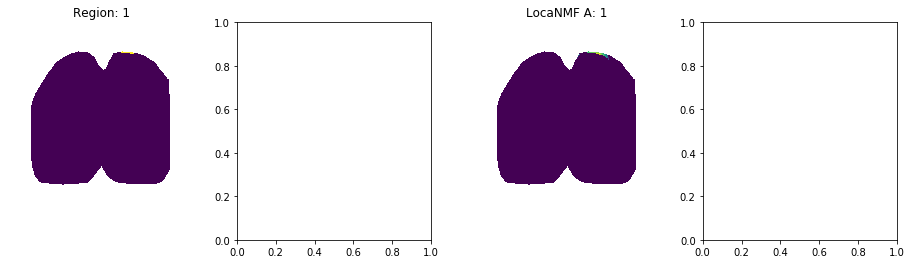

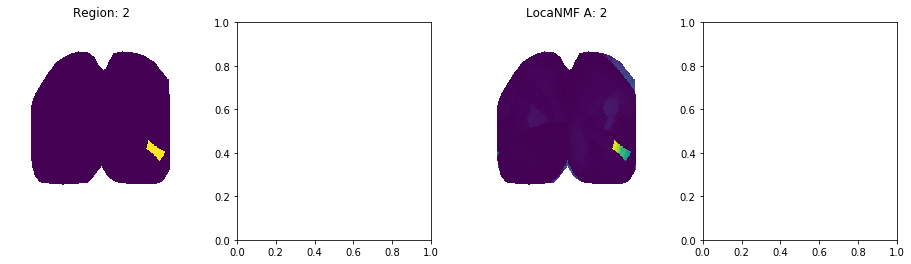

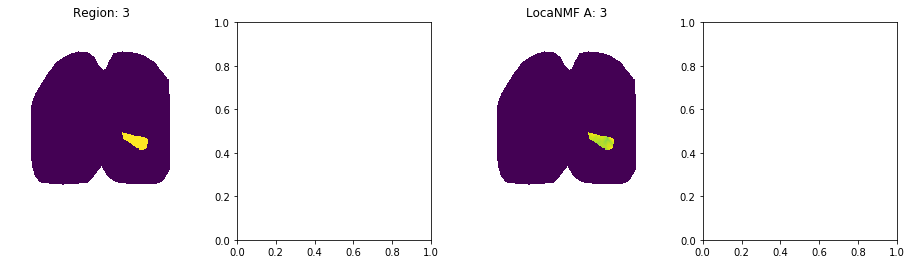

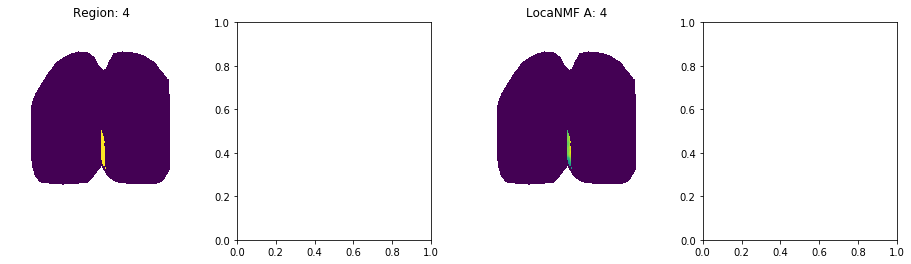

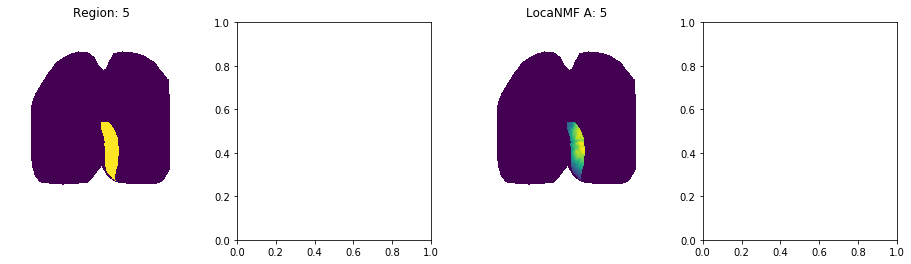

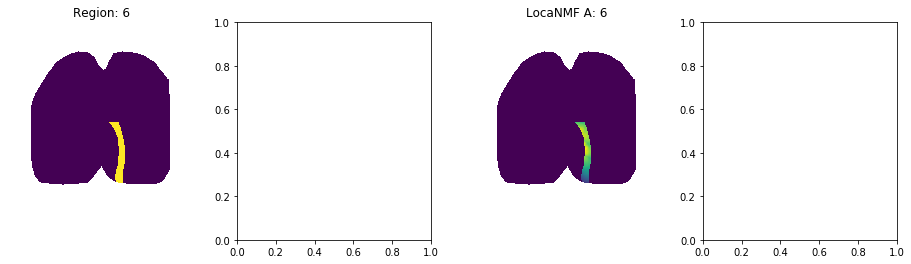

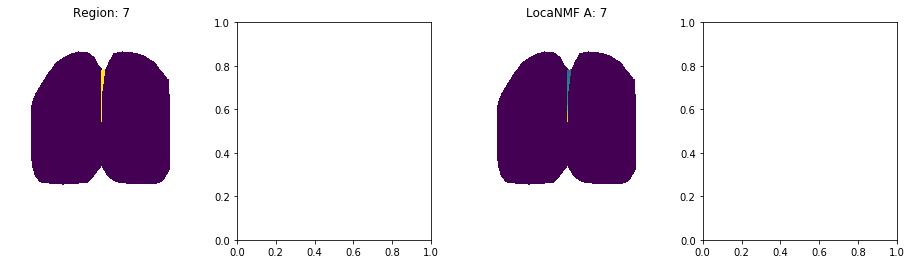

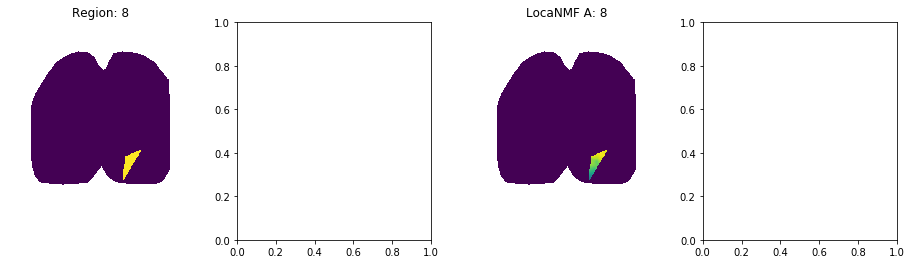

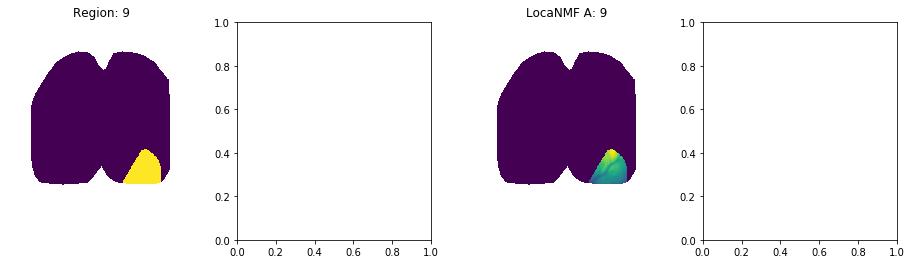

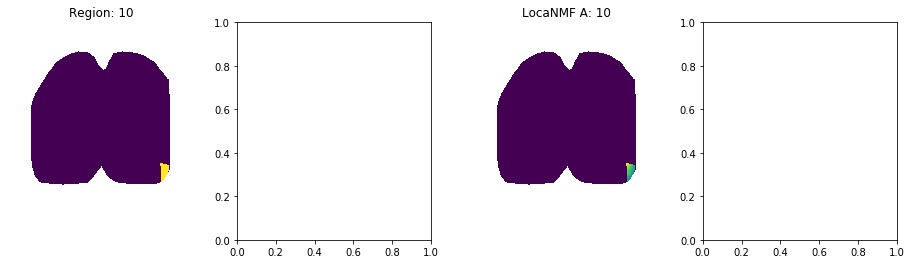

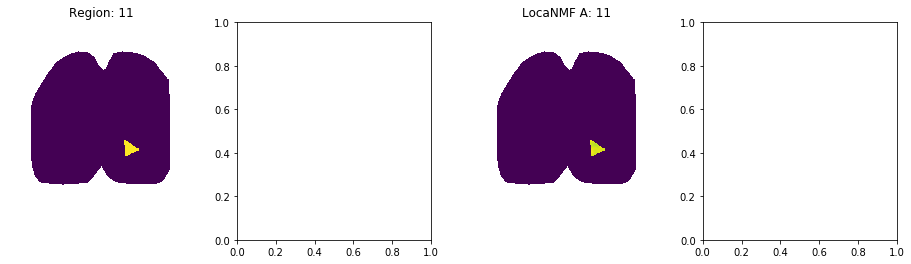

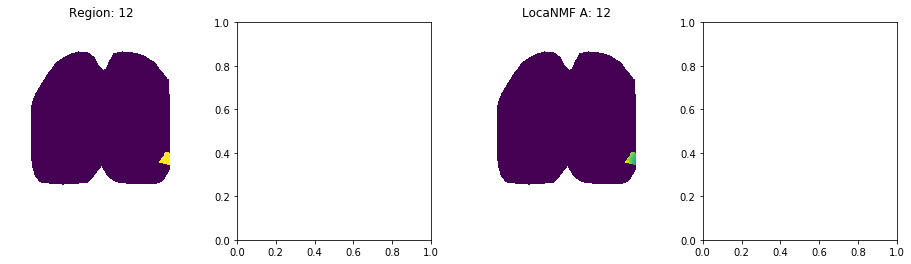

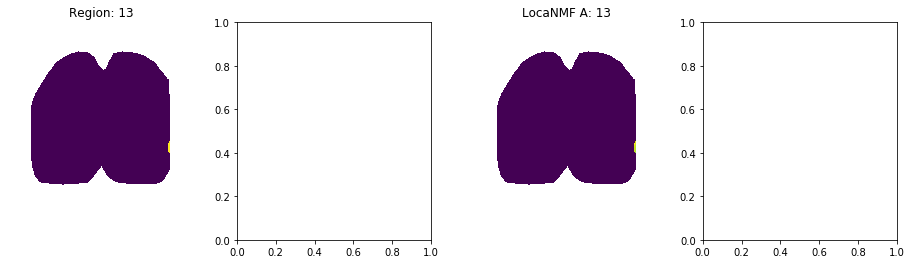

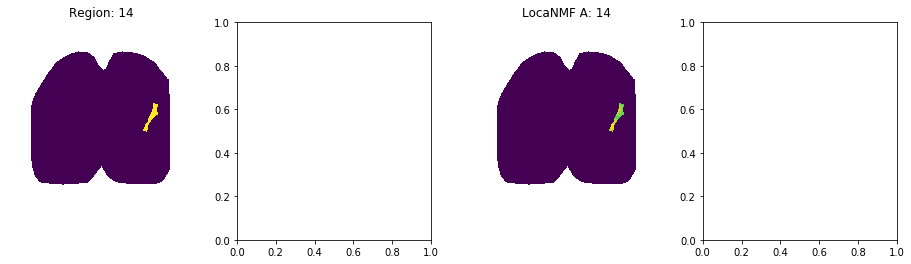

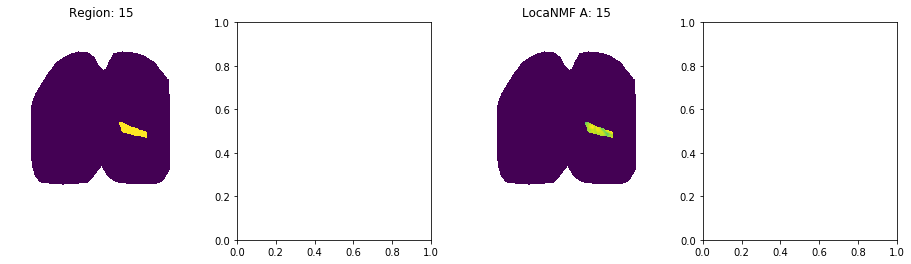

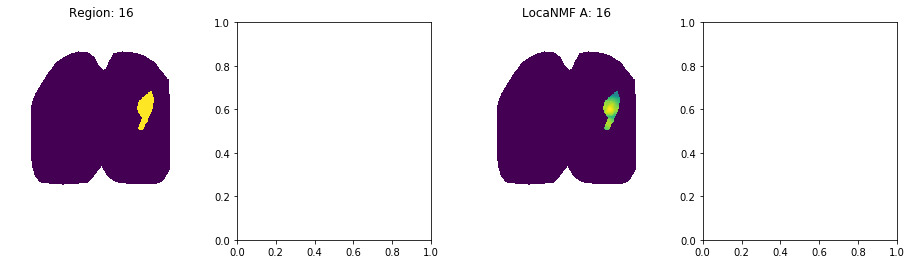

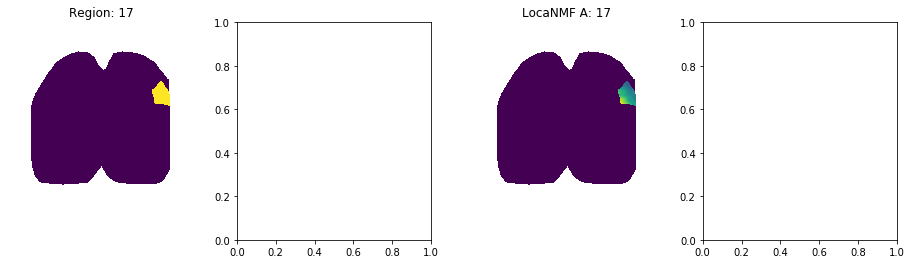

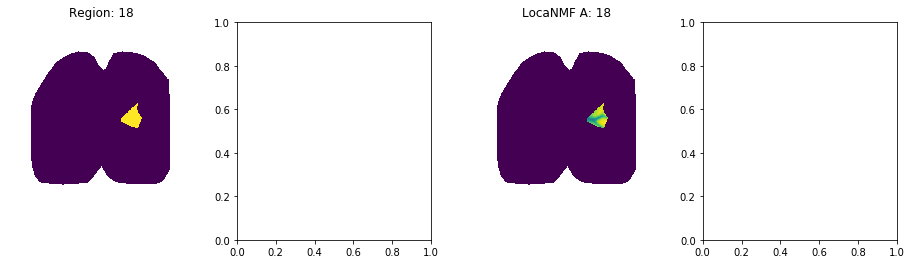

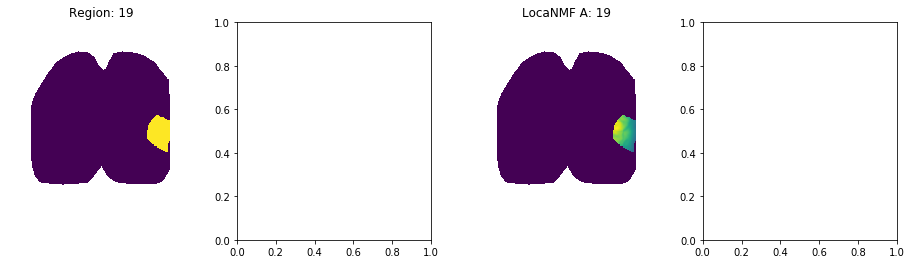

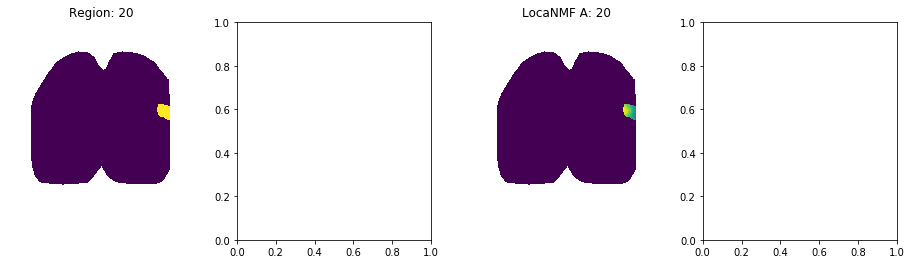

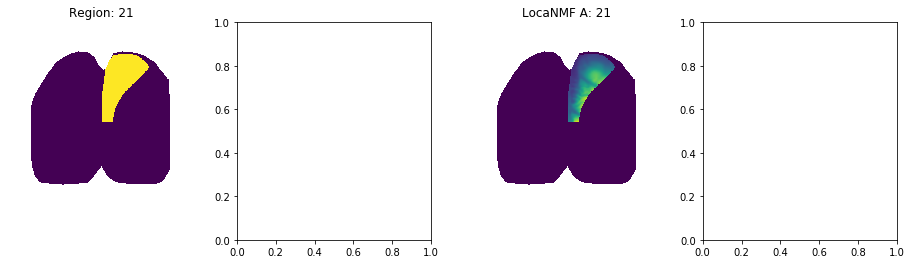

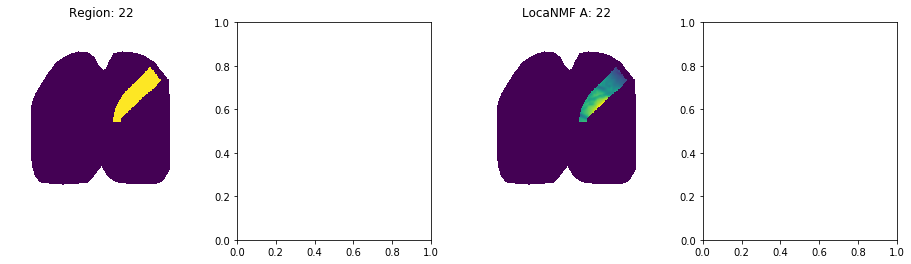

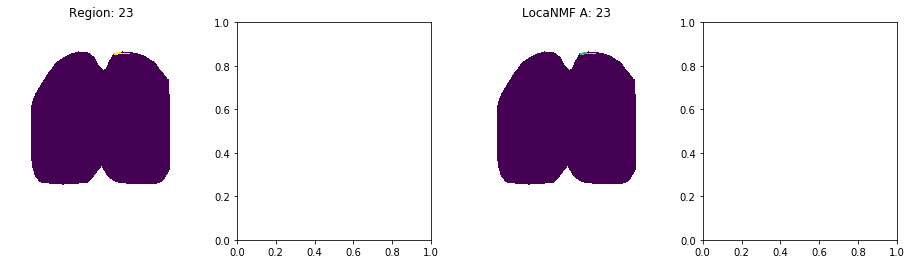

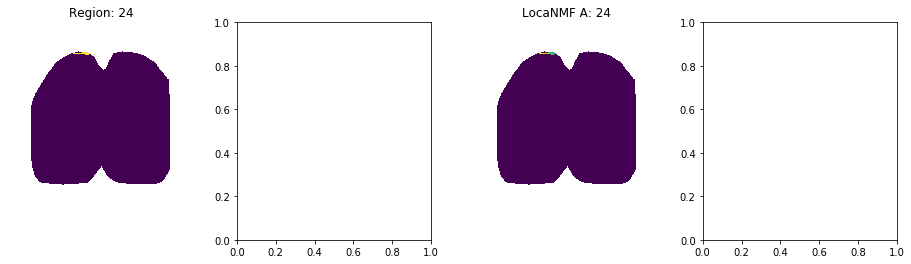

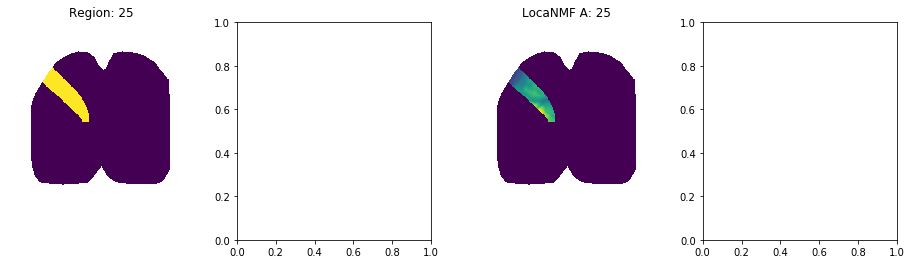

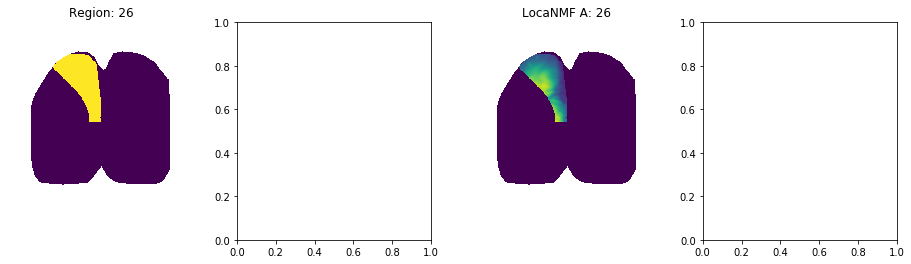

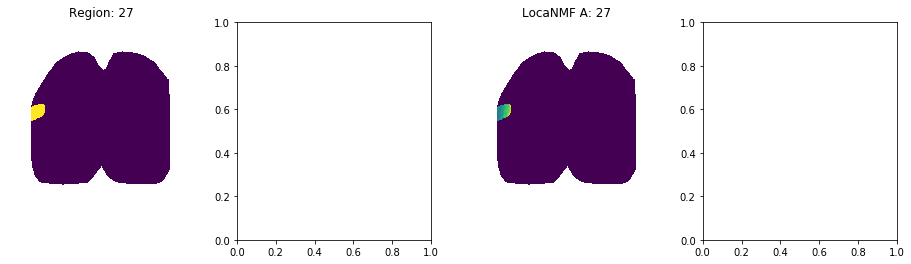

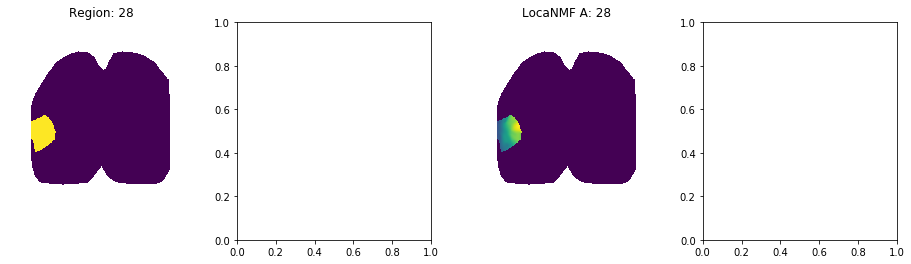

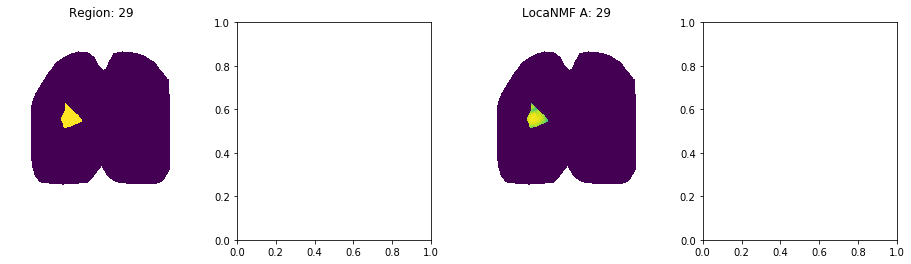

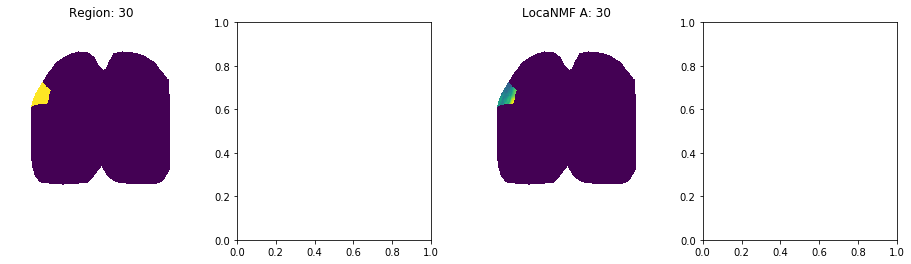

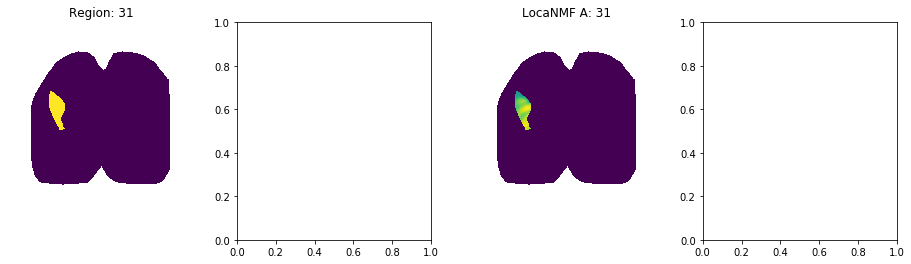

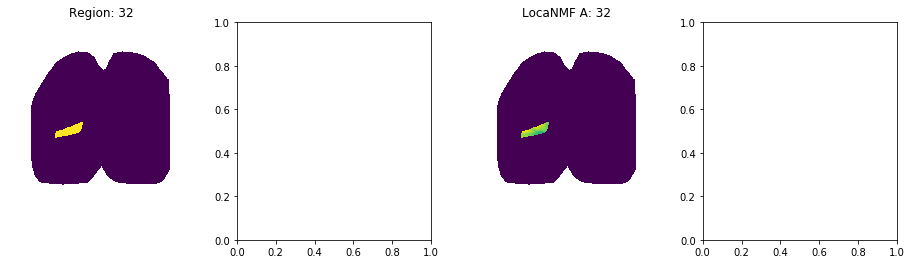

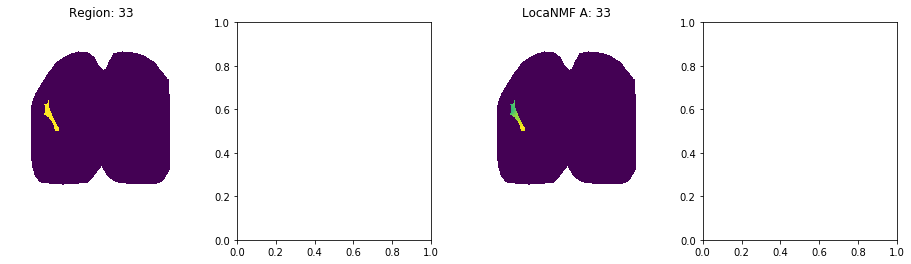

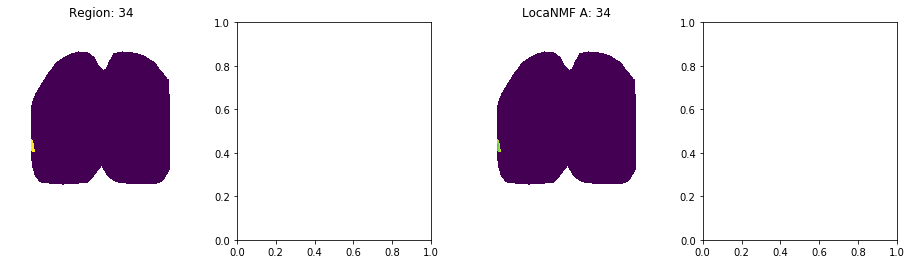

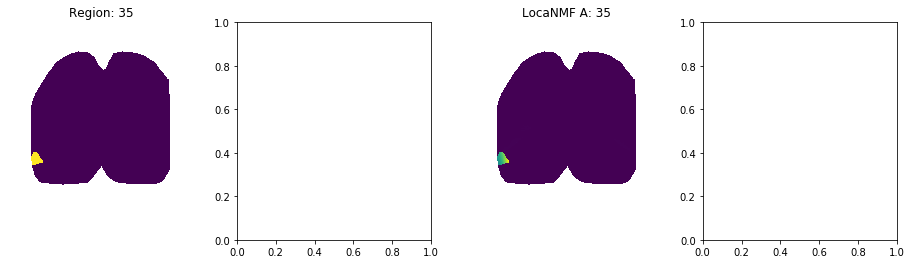

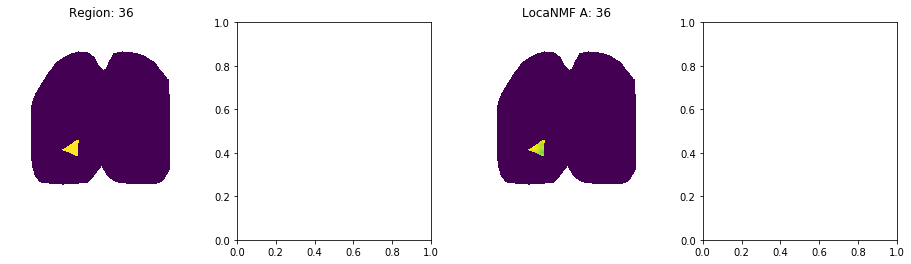

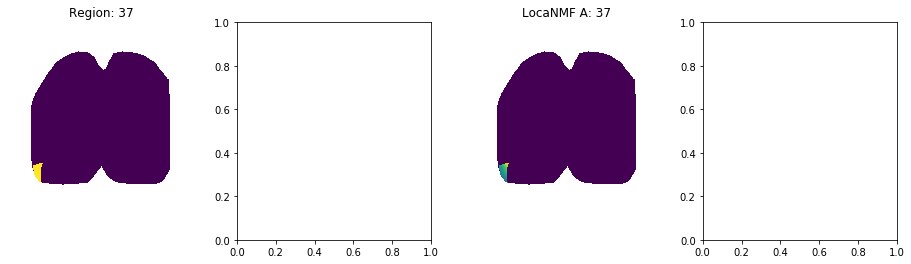

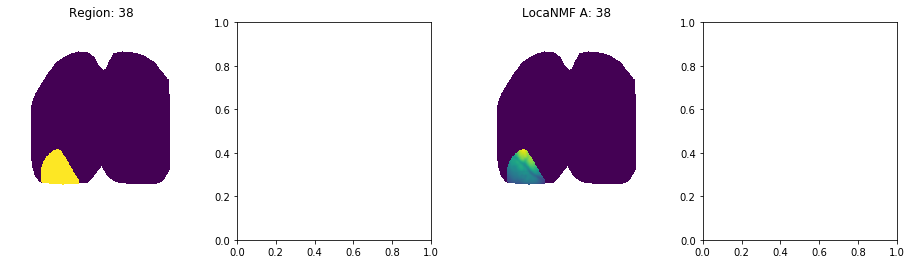

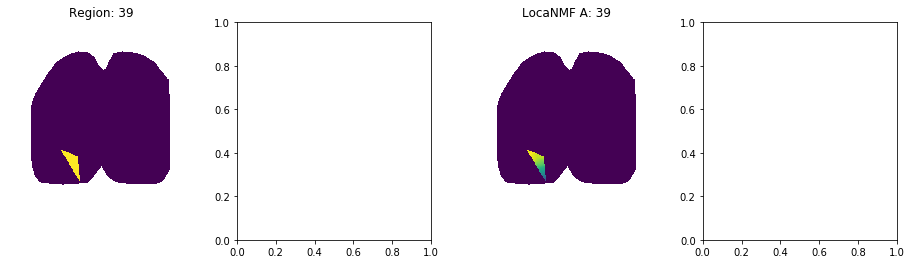

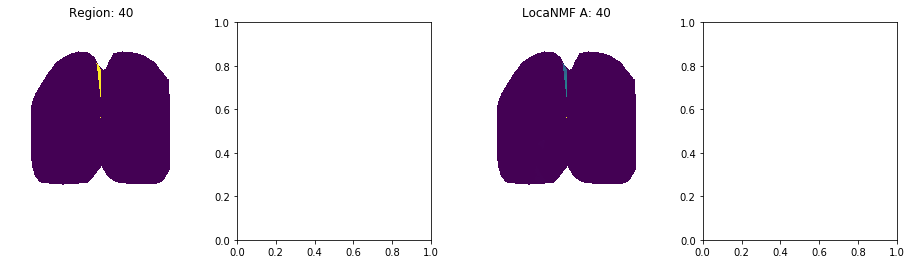

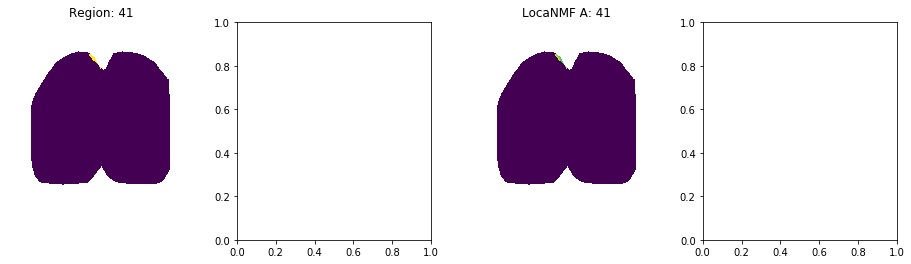

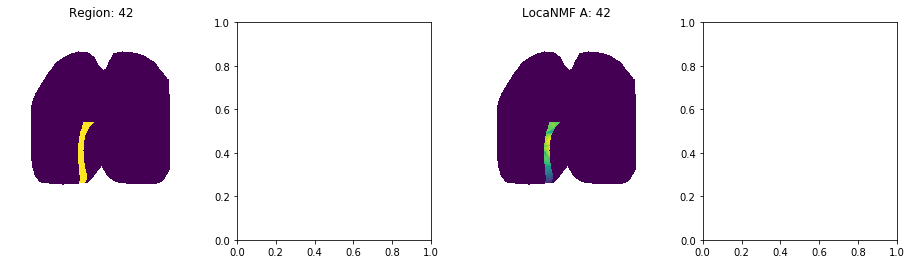

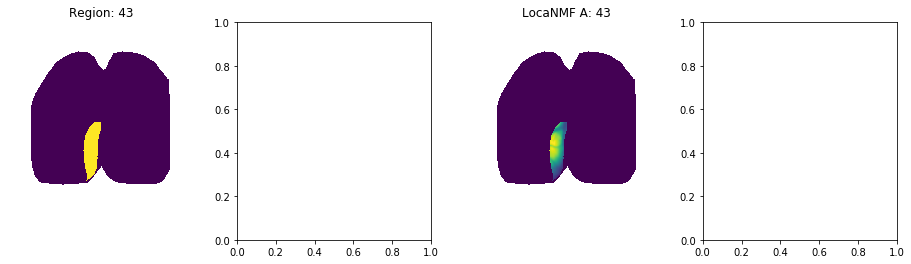

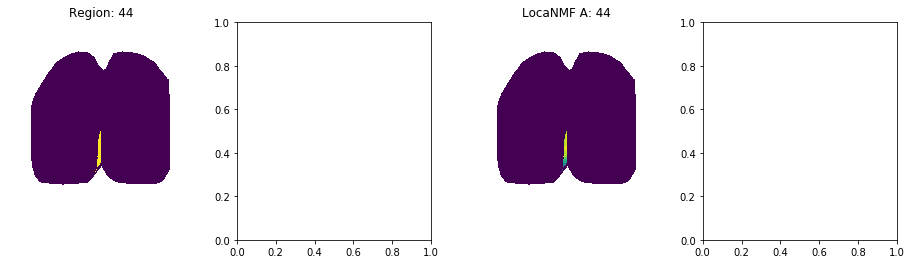

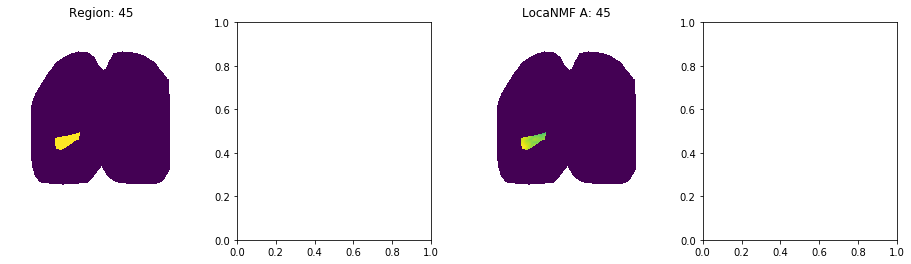

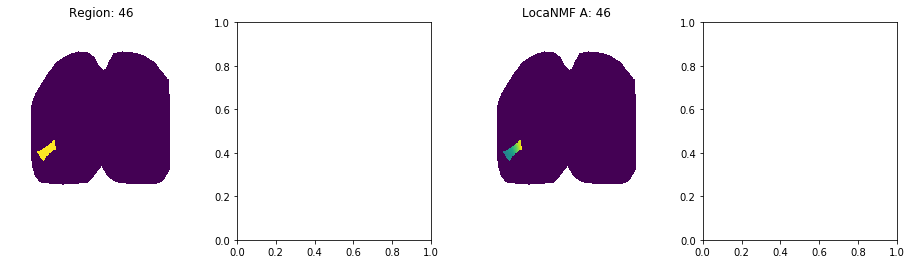

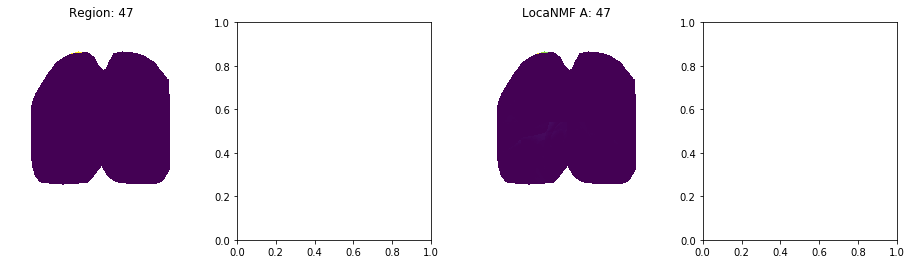

In [83]:
# Plotting all the regions' components
A_validmask=np.zeros((brainmask_full.shape[0],brainmask_full.shape[1])); A_validmask.fill(np.nan)
for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1):
    fig, axs = plt.subplots(1 + int((1+region_ranks[rdx]) / 4), 4,
                            figsize=(16,(1 + int((1+region_ranks[rdx]) / 4)) * 4))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A_validmask[brainmask_full] = locanmf_comps.distance.data[i].cpu()==0
    axs[0].imshow(A_validmask)
    axs[0].set_title("Region: {}".format(rdx+1)); axs[0].axis('off')
    
    # only for simulated data
    #A_validmask[brainmask_full]=video_mats[0][:,np.where(areas[i]==trueareas)[0][0]]
    #axs[1].imshow(A_validmask)
    #axs[1].set_title("True A: {}".format(rdx+1)); axs[1].axis('off')
    
    axs[2].imshow(A_reshape[:,:,i])
    axs[2].set_title("LocaNMF A: {}".format(i+1)); axs[2].axis('off')
    
#     axs[3].plot(V[np.where(areas[i]==trueareas)[0][0],:3000].T,'k'); axs[3].plot(C[i,:3000].T,'r');
#     axs[3].set_title("True & LocaNMF C: {}".format(i+1));axs[3].axis('off'); 
#     if i==0: axs[3].legend(('True','LocaNMF'))
    
    plt.show()

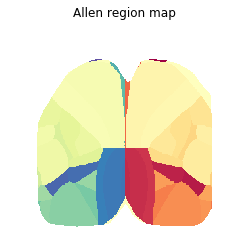

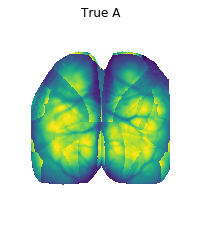

In [84]:
# Plot the maximum U for each pixel
plotmap=np.zeros((dorsalMapScaled.shape)); plotmap.fill(np.nan); plotmap[brainmask]=dorsalMapScaled[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(A_reshape,axis=2)); plt.axis('off'); plt.title('True A'); plt.show()

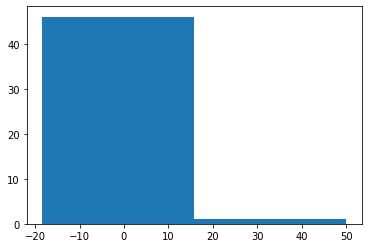

In [85]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(np.log(locanmf_comps.lambdas.data.cpu()), bins=torch.unique(locanmf_comps.lambdas.data).shape[0])
plt.show()

In [26]:
datafolder = os.path.split(fname)[0]+"/"
sio.savemat(datafolder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C,
             'A':A_reshape,
             'lambdas':locanmf_comps.lambdas.data.cpu().numpy(),
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests
            })

In [21]:
torch.cuda.empty_cache()

['bodyparts', 'left_paw', 'left_paw', 'left_paw', 'right_paw', 'right_paw', 'right_paw', 'nose', 'nose', 'nose', 'lever', 'lever', 'lever', 'right_ear', 'right_ear', 'right_ear', 'jaw', 'jaw', 'jaw', 'tongue', 'tongue', 'tongue']
(20028, 22)


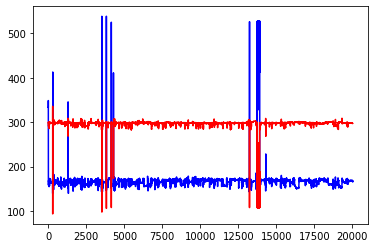

In [11]:
# make random data times;
import numpy as np
import matplotlib.pyplot as plt

# load time traces from 
import csv
fname = '/media/cat/1TB/data/yuki/dlc_models/yuki-cat-2020-05-11/videos/IA2pm_Apr22_Week2_30HzDLC_resnet50_yukiMay11shuffle1_1030000.csv'
with open(fname, newline='') as csvfile:
    data = list(csv.reader(csvfile))

    
labels = data[1]
print (labels)
traces = np.array(data[3:])
print (traces.shape)
start_idx = 10
lever = np.float32(traces[:,start_idx:start_idx+3])

fig=plt.figure()
plt.plot(lever[:,0], c='blue')
plt.plot(lever[:,1], c='red')
plt.show()